# Reproductionl for Cell-type Identification
In this tutorial, we provide code for reproducing our experiment in the cell type identification task. Some of our code was reused from the official scGPT code, while others were modified by us. And we have also indicated this in the following modules.

We summarize this pipeline in the following steps:

     1. Specify hyper-parameter setup for cell type identification task
     
     2. K-fold cross validation PEFT scGPT model
     

In [1]:
# %%
import copy
import json
import os
from pathlib import Path
import shutil
import sys
import time
import warnings
import pandas as pd
import pickle
import torch
import scanpy as sc
import argparse
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

sys.path.insert(0, "../../")
import scgpt as scg
from scgpt.trainer import (
    test,
    train,
    evaluate,
    prepare_data,
    prepare_dataloader
)
from scgpt.loss import masked_mse_loss
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed, PeftConfig, DownstreamTasks
from reproduction_util import load_and_process_data, get_weighted_sampler, initialize_model

sc.set_figure_params(figsize=(6, 6))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/users/PCON0022/coffee19850519/ondemand/scGPT_prompt/reproduction/script/../../scgpt/model/model.py:22: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/users/PCON0022/coffee19850519/ondemand/scGPT_prompt/reproduction/script/../../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step1: Specify hyper-parameter setup for cell-type identification task

The hyper-parameters used below, except for ***peft***, are all reused from the official scGPT. The hyper-parameter ***peft*** is used to control  whether training the model using PEFT, False to disable, "HYBRID"/"ENCODER"/"TOKEN"/"PREFIX"/"LORA" are available for selection

In [2]:
hyperparameter_defaults = dict(
    seed=0,
    dataset_name="ms",
    do_train=True,
    load_model="../../save/scGPT_human",
    mask_ratio=0.0,
    epochs=25,
    n_bins=51,
    MVC=False,  # Masked value prediction for cell embedding
    ecs_thres=0.0,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=0.0,
    lr=5e-5,
    batch_size=50,
    dropout=0.2,  # dropout probability
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    fast_transformer=False,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
    include_zero_gene=False,
    freeze=False,  # freeze
    DSBN=False,  # Domain-spec batchnorm
    peft="ENCODER"
    # Whether using Parameter-Efficient Fine-Tuning,
    # False to disable, HYBRID/ENCODER/TOKEN/PREFIX/LORA are available for selection
)

config = argparse.Namespace(**hyperparameter_defaults)
set_seed(config.seed)

Next is the PeftConfig. If you want to see the meaning of adapter related parameters, you can use `help(PeftConfig)` to view them. Here we are using the optimal parameter combination from our experiment. If you want to modify the parameters, you can do the following:
Examples: ` PeftConfig(peft_type="LORA", r=8, lora_alpha=1).to_dict()`
For more details, go to scgpt.utils.PeftConfig

In [3]:
# settings for parameter efficient fine tuning
assert config.peft in [False, "HYBRID", "ENCODER", "TOKEN", "PREFIX", "LORA"]
peft_config = PeftConfig(peft_type=config.peft).to_dict()

config.peft_config = peft_config
for k,v in peft_config.items():
    print(f"{k} -> {v}")

peft_type -> ENCODER
mlp_ratio -> 0.25
skip_connect -> True
adapter_layer_conf -> [True, True, True, True, True, True, False, False, False, False, False, False]
ENCODER_FLAG -> True


We still reuse the official scGPT code for the following modules

In [6]:
# settings for input and preprocessing
config.pad_token = pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_value = "auto"  # for masked values, now it should always be auto

config.max_seq_len = 2001
n_bins = config.n_bins

# input/output representation
config.input_style = "binned"  # "normed_raw", "log1p", or "binned"
config.output_style = "binned"  # "normed_raw", "log1p", or "binned"

# settings for training
config.MLM = False  # whether to use masked language modeling, currently it is always on.
config.CLS = True  # celltype classification objective
config.ADV = False  # Adversarial training for batch correction
config.CCE = False  # Contrastive cell embedding objective
MVC = config.MVC  # Masked value prediction for cell embedding
config.ECS = config.ecs_thres > 0  # Elastic cell similarity objective
config.DAB = False  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
config.GEP = False  # Gene expression modelling
config.GEPC = MVC  # Gene expression modelling for cell objective
config.use_batch_labels = config.INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier
config.input_emb_style = "continuous"  # "category" or "continuous" or "scaling"
config.cell_emb_style = "cls"  # "avg-pool" or "w-pool" or "cls"
adv_E_delay_epochs = 0  # delay adversarial training on encoder for a few epochs
adv_D_delay_epochs = 0
config.mvc_decoder_style = "inner product"
config.ecs_threshold = config.ecs_thres
config.task = DownstreamTasks.Identification.value

config.explicit_zero_prob = explicit_zero_prob = config.MLM and config.include_zero_gene  # whether explicit bernoulli for zeros
do_sample_in_train = False and explicit_zero_prob  # sample the bernoulli in training

per_seq_batch_sample = False

# settings for optimizer
lr = config.lr  # TODO: test learning rate ratio between two tasks
lr_ADV = 1e-3  # learning rate for discriminator, used when ADV is True
early_stop = 7
batch_size = config.batch_size
eval_batch_size = config.batch_size
epochs = config.epochs
schedule_interval = 1

# settings for the model
fast_transformer = config.fast_transformer
config.fast_transformer_backend = fast_transformer_backend = "flash"  # "linear" or "flash"
dropout = config.dropout  # dropout probability

# logging
config.log_interval = 100  # iterations
save_eval_interval = config.save_eval_interval  # epochs
do_eval_scib_metrics = True

print(config)

Namespace(seed=0, dataset_name='ms', do_train=True, load_model='../../save/scGPT_human', mask_ratio=0.0, epochs=25, n_bins=51, MVC=False, ecs_thres=0.0, dab_weight=0.0, lr=5e-05, batch_size=50, dropout=0.2, schedule_ratio=0.9, save_eval_interval=5, fast_transformer=False, pre_norm=False, amp=True, include_zero_gene=False, freeze=False, DSBN=False, peft='ENCODER', peft_config={'peft_type': 'ENCODER', 'mlp_ratio': 0.25, 'skip_connect': True, 'adapter_layer_conf': [True, True, True, True, True, True, False, False, False, False, False, False], 'ENCODER_FLAG': True}, pad_token='<pad>', max_seq_len=2001, input_style='binned', output_style='binned', MLM=False, CLS=True, ADV=False, CCE=False, ECS=False, DAB=False, GEP=False, GEPC=False, use_batch_labels=False, INPUT_BATCH_LABELS=False, input_emb_style='continuous', cell_emb_style='cls', mvc_decoder_style='inner product', ecs_threshold=0.0, task='identification', explicit_zero_prob=False, fast_transformer_backend='flash', log_interval=100)


In [7]:
# %% validate settings
assert config.input_style in ["normed_raw", "log1p", "binned"]
assert config.output_style in ["normed_raw", "log1p", "binned"]
assert config.input_emb_style in ["category", "continuous", "scaling"]
if config.input_style == "binned":
    if config.input_emb_style == "scaling":
        raise ValueError("input_emb_style `scaling` is not supported for binned input.")
elif config.input_style == "log1p" or config.input_style == "normed_raw":
    if config.input_emb_style == "category":
        raise ValueError(
            "input_emb_style `category` is not supported for log1p or normed_raw input."
        )

if config.input_emb_style == "category":
    config.mask_value = mask_value = n_bins + 1
    config.pad_value = pad_value = n_bins  # for padding gene expr values
    config.n_input_bins = n_input_bins = n_bins + 2
else:
    config.mask_value = mask_value = -1
    config.pad_value = pad_value = -2
    config.n_input_bins = n_input_bins = n_bins

if config.ADV and config.DAB:
    raise ValueError("ADV and DAB cannot be both True.")
DAB_separate_optim = True if config.DAB > 1 else False

config.input_layer_key = {  # the values of this map coorespond to the keys in preprocessing
    "normed_raw": "X_normed",
    "log1p": "X_normed",
    "binned": "X_binned",
}[config.input_style]

In [8]:
dataset_name = config.dataset_name
save_dir = Path(f"../save/reproduction_{dataset_name}_peft_{config.peft}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to ../save/reproduction_ms_peft_ENCODER


In [9]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    shutil.copy(vocab_file, save_dir / "vocab.json")
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)

    config.embsize = embsize = model_configs["embsize"]
    config.nhead = nhead = model_configs["nheads"]
    config.d_hid = d_hid = model_configs["d_hid"]
    config.nlayers = nlayers = model_configs["nlayers"]
    config.n_layers_cls = n_layers_cls = model_configs["n_layers_cls"]


## Step2: K-fold cross validation PEFT scGPT model
In this step, it includes:

     1. Load and pre-process data
     
     2. Load the pre-trained scGPT model
     
     3. PEFT scGPT with CLS objective
     
     4. Evaluate PEFT scGPT

scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - FOLD: 0
scGPT - INFO - match 2000/2000 genes in vocabulary of size 60697.
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Binning data ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Binning data ...
scGPT - INFO - train set number of samples: 15751, 
	 feature length: 762
scGPT - INFO - valid set number of samples: 1649, 
	 feature length: 668
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Learnable params transformer_encoder.layers.0.space_adapter.fc1.weight with shape torch.Size([128, 512])
scGPT - INFO - Learnable params transformer_encoder.layers.0.space_adapter.fc1.bias with shape torch.Size([128])
scGPT - INFO - Learnable params transformer_encoder.layers.0.space_adapter.fc2.weight with shape torch.Size([512, 128])
scGPT - INFO - Learnable params transformer_encod

scGPT - INFO - | epoch   2 | 300/316 batches | lr 0.00005 | ms/batch 316.85 | loss  0.30 | cls  0.30 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   2 | time: 103.40s | valid loss/mse 0.4690
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 0.4690
scGPT - INFO - | epoch   3 | 100/316 batches | lr 0.00004 | ms/batch 320.21 | loss  0.28 | cls  0.28 | 
scGPT - INFO - | epoch   3 | 200/316 batches | lr 0.00004 | ms/batch 316.77 | loss  0.25 | cls  0.25 | 
scGPT - INFO - | epoch   3 | 300/316 batches | lr 0.00004 | ms/batch 316.76 | loss  0.26 | cls  0.26 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   3 | time: 103.37s | valid loss/mse 0.4195
scGPT - INFO - --------------------------------------------------------------

scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | epoch  16 | 100/316 batches | lr 0.00001 | ms/batch 319.69 | loss  0.14 | cls  0.14 | 
scGPT - INFO - | epoch  16 | 200/316 batches | lr 0.00001 | ms/batch 316.44 | loss  0.14 | cls  0.14 | 
scGPT - INFO - | epoch  16 | 300/316 batches | lr 0.00001 | ms/batch 316.50 | loss  0.14 | cls  0.14 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  16 | time: 103.26s | valid loss/mse 0.4231
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | epoch  17 | 100/316 batches | lr 0.00001 | ms/batch 319.63 | loss  0.12 | cls  0.12 | 
scGPT - INFO - | epoch  17 | 200/316 batches | lr 0.00001 | ms/batch 316.48 | loss  0.14 | cls  0.14 | 
scGPT - INFO - | epoch  17 | 300/316 batches | lr 0.00001 | ms/batch 316.43 | loss  0.13 | 

scGPT - INFO - | epoch   1 | 100/259 batches | lr 0.00005 | ms/batch 388.73 | loss  1.98 | cls  1.98 | 
scGPT - INFO - | epoch   1 | 200/259 batches | lr 0.00005 | ms/batch 385.07 | loss  0.65 | cls  0.65 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   1 | time: 103.56s | valid loss/mse 0.5149
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 0.5149
scGPT - INFO - | epoch   2 | 100/259 batches | lr 0.00005 | ms/batch 389.10 | loss  0.42 | cls  0.42 | 
scGPT - INFO - | epoch   2 | 200/259 batches | lr 0.00005 | ms/batch 385.27 | loss  0.34 | cls  0.34 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   2 | time: 103.63s | valid loss/mse 0.4331
scGPT - INFO - --------------------------------------------------------------

scGPT - INFO - Learnable params transformer_encoder.layers.1.space_adapter.fc1.weight with shape torch.Size([128, 512])
scGPT - INFO - Learnable params transformer_encoder.layers.1.space_adapter.fc1.bias with shape torch.Size([128])
scGPT - INFO - Learnable params transformer_encoder.layers.1.space_adapter.fc2.weight with shape torch.Size([512, 128])
scGPT - INFO - Learnable params transformer_encoder.layers.1.space_adapter.fc2.bias with shape torch.Size([512])
scGPT - INFO - Learnable params transformer_encoder.layers.2.space_adapter.fc1.weight with shape torch.Size([128, 512])
scGPT - INFO - Learnable params transformer_encoder.layers.2.space_adapter.fc1.bias with shape torch.Size([128])
scGPT - INFO - Learnable params transformer_encoder.layers.2.space_adapter.fc2.weight with shape torch.Size([512, 128])
scGPT - INFO - Learnable params transformer_encoder.layers.2.space_adapter.fc2.bias with shape torch.Size([512])
scGPT - INFO - Learnable params transformer_encoder.layers.3.space_a

scGPT - INFO - Best model with score 0.4253
scGPT - INFO - | epoch   4 | 100/342 batches | lr 0.00004 | ms/batch 380.69 | loss  0.23 | cls  0.23 | 
scGPT - INFO - | epoch   4 | 200/342 batches | lr 0.00004 | ms/batch 376.75 | loss  0.21 | cls  0.21 | 
scGPT - INFO - | epoch   4 | 300/342 batches | lr 0.00004 | ms/batch 376.83 | loss  0.22 | cls  0.22 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   4 | time: 131.39s | valid loss/mse 0.4470
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | epoch   5 | 100/342 batches | lr 0.00003 | ms/batch 380.56 | loss  0.22 | cls  0.22 | 
scGPT - INFO - | epoch   5 | 200/342 batches | lr 0.00003 | ms/batch 376.77 | loss  0.20 | cls  0.20 | 
scGPT - INFO - | epoch   5 | 300/342 batches | lr 0.00003 | ms/batch 376.75 | loss  0.21 | cls  0.21 | 
scGPT - INFO - ---------------------------------

scGPT - INFO - Learnable params cls_decoder._decoder.3.bias with shape torch.Size([512])
scGPT - INFO - Learnable params cls_decoder._decoder.5.weight with shape torch.Size([512])
scGPT - INFO - Learnable params cls_decoder._decoder.5.bias with shape torch.Size([512])
scGPT - INFO - Learnable params cls_decoder.out_layer.weight with shape torch.Size([18, 512])
scGPT - INFO - Learnable params cls_decoder.out_layer.bias with shape torch.Size([18])
scGPT - INFO - Total Pre freeze Params: 52.13M
scGPT - INFO - Total Post freeze Params: 1.33M
scGPT - INFO - TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerN

scGPT - INFO - | end of epoch   8 | time: 128.80s | valid loss/mse 0.3907
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | epoch   9 | 100/325 batches | lr 0.00002 | ms/batch 391.46 | loss  0.17 | cls  0.17 | 
scGPT - INFO - | epoch   9 | 200/325 batches | lr 0.00002 | ms/batch 387.46 | loss  0.17 | cls  0.17 | 
scGPT - INFO - | epoch   9 | 300/325 batches | lr 0.00002 | ms/batch 387.51 | loss  0.17 | cls  0.17 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   9 | time: 128.81s | valid loss/mse 0.4168
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | epoch  10 | 100/325 batches | lr 0.00002 | ms/batch 391.35 | loss  0.17 | cls  0.17 | 
scGPT - INFO - | epoch  10 | 200/325 batches | lr 0.00002 | ms/batch 387.41 | loss  0.16 | cls  0.16 | 
scGPT - INFO - | 

scGPT - INFO - | epoch   1 | 100/312 batches | lr 0.00005 | ms/batch 373.82 | loss  1.88 | cls  1.88 | 
scGPT - INFO - | epoch   1 | 200/312 batches | lr 0.00005 | ms/batch 370.45 | loss  0.62 | cls  0.62 | 
scGPT - INFO - | epoch   1 | 300/312 batches | lr 0.00005 | ms/batch 370.11 | loss  0.44 | cls  0.44 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   1 | time: 118.06s | valid loss/mse 0.5884
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 0.5884
scGPT - INFO - | epoch   2 | 100/312 batches | lr 0.00005 | ms/batch 374.08 | loss  0.37 | cls  0.37 | 
scGPT - INFO - | epoch   2 | 200/312 batches | lr 0.00005 | ms/batch 370.03 | loss  0.34 | cls  0.34 | 
scGPT - INFO - | epoch   2 | 300/312 batches | lr 0.00005 | ms/batch 370.01 | loss  0.32 | cls  0.32 | 
scGPT - INFO - ---------------------------------

scGPT - INFO - | epoch  14 | 300/312 batches | lr 0.00001 | ms/batch 370.43 | loss  0.16 | cls  0.16 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  14 | time: 118.13s | valid loss/mse 0.4149
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | epoch  15 | 100/312 batches | lr 0.00001 | ms/batch 374.04 | loss  0.15 | cls  0.15 | 
scGPT - INFO - | epoch  15 | 200/312 batches | lr 0.00001 | ms/batch 370.45 | loss  0.14 | cls  0.14 | 
scGPT - INFO - | epoch  15 | 300/312 batches | lr 0.00001 | ms/batch 370.40 | loss  0.17 | cls  0.17 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  15 | time: 118.13s | valid loss/mse 0.4119
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - |

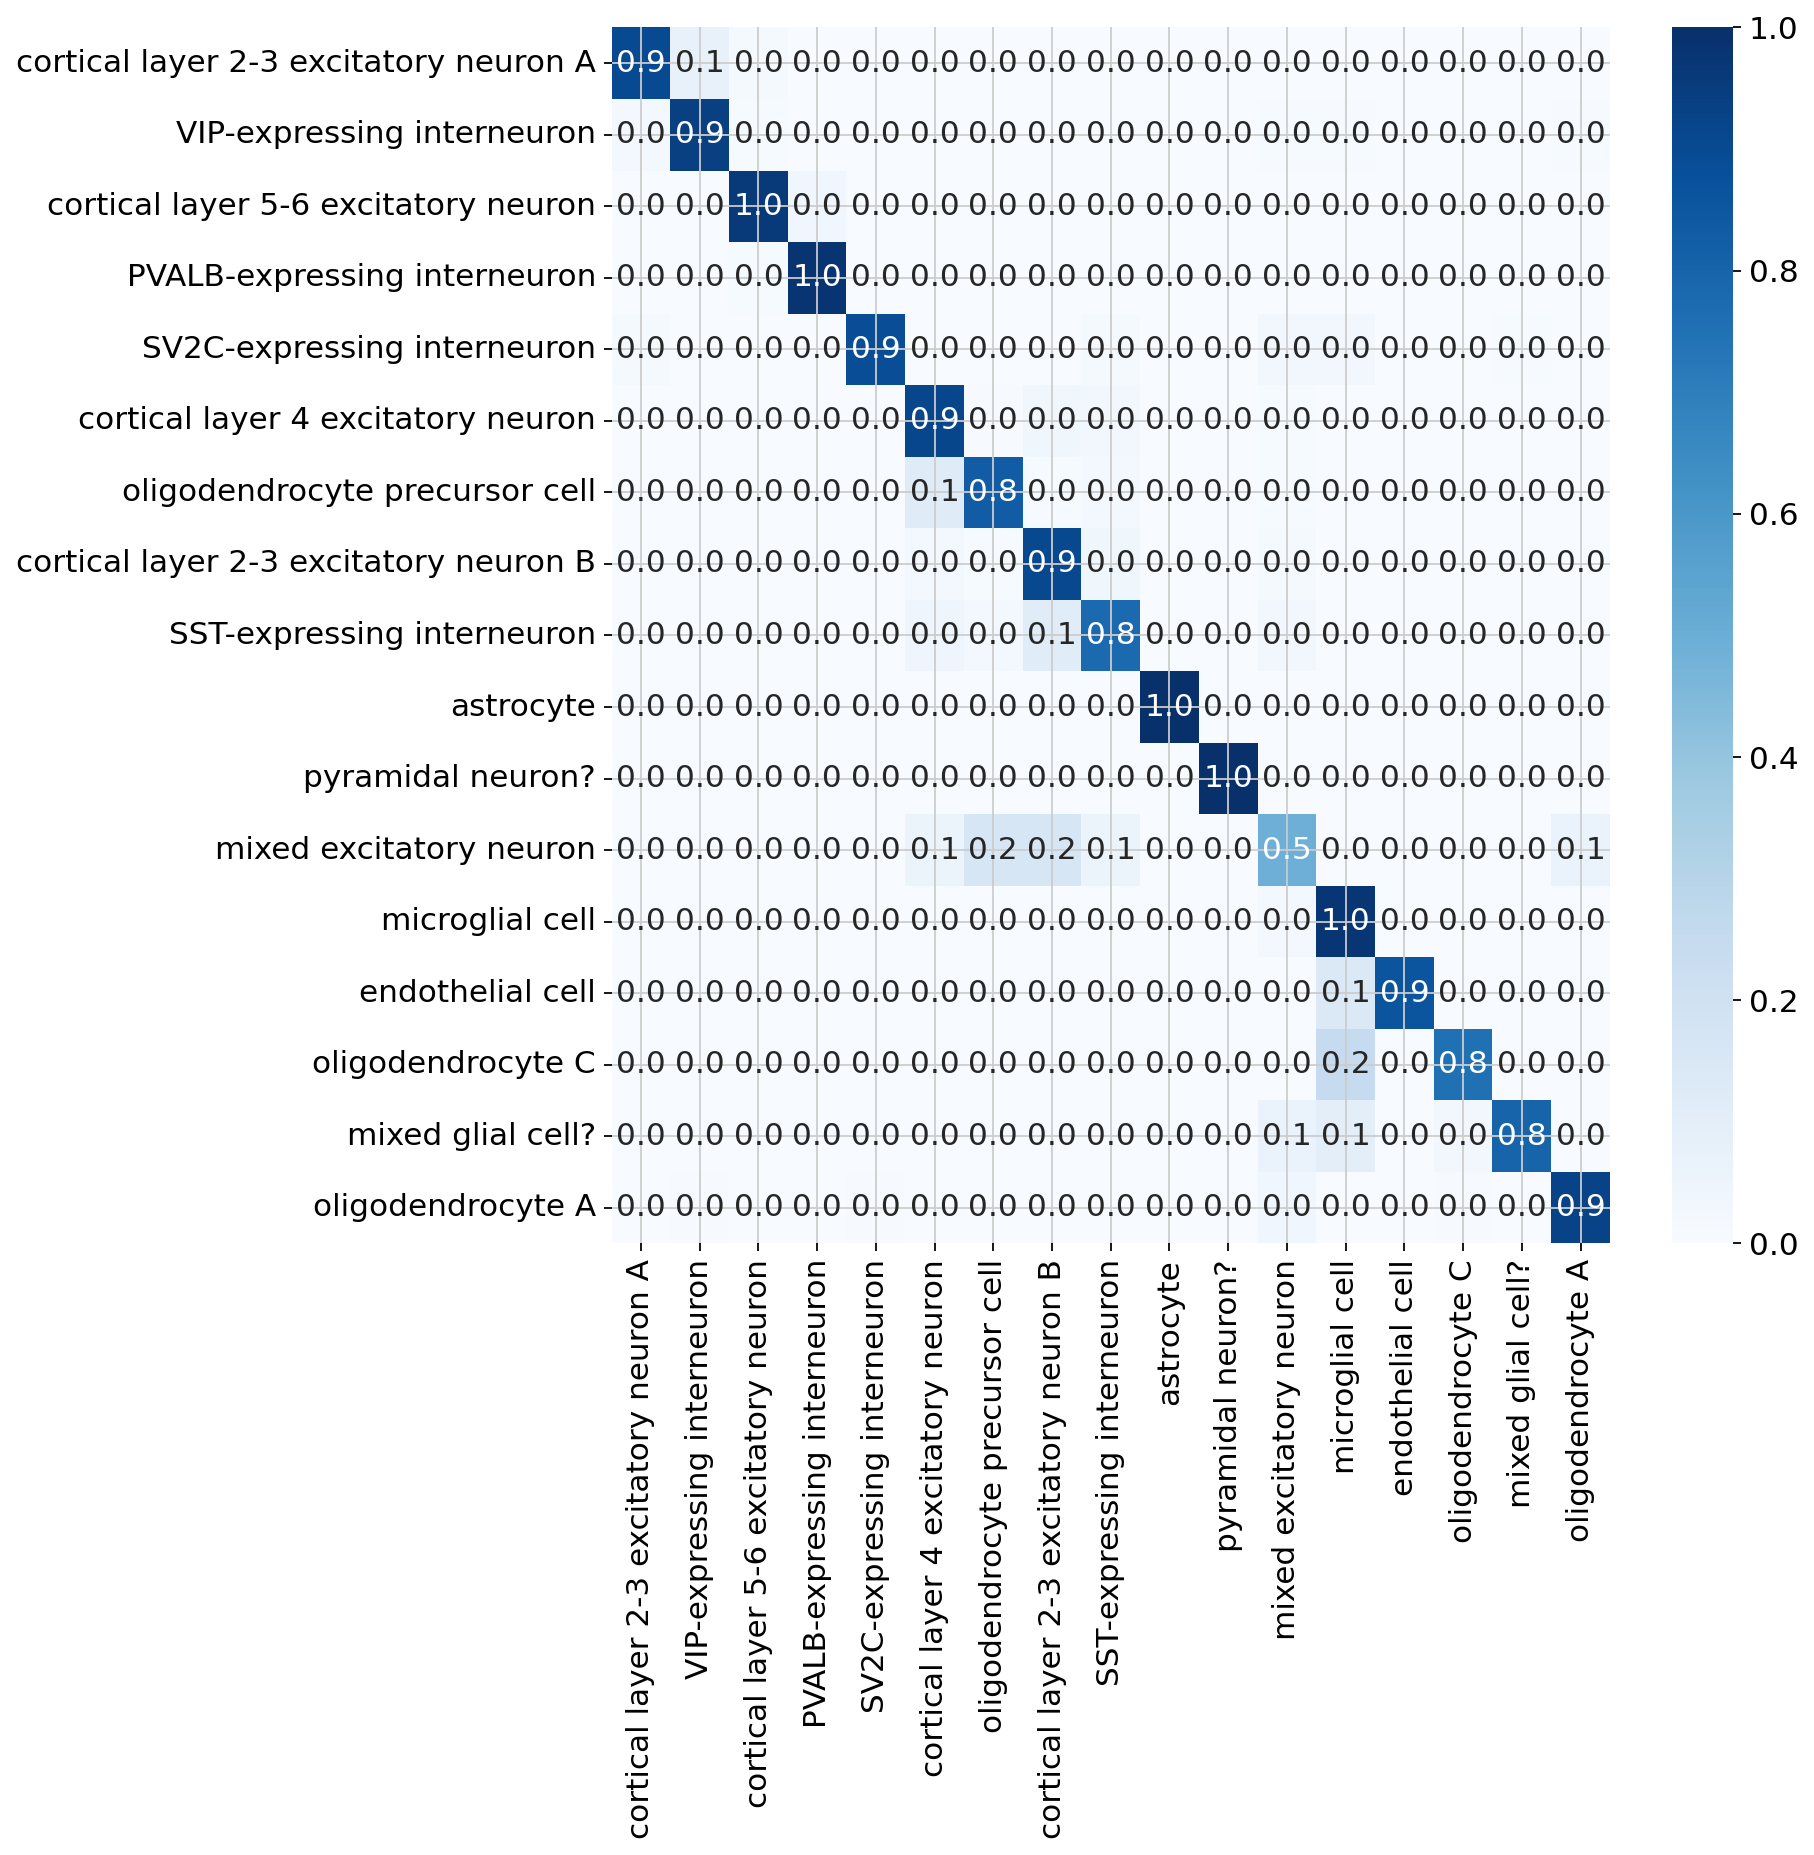

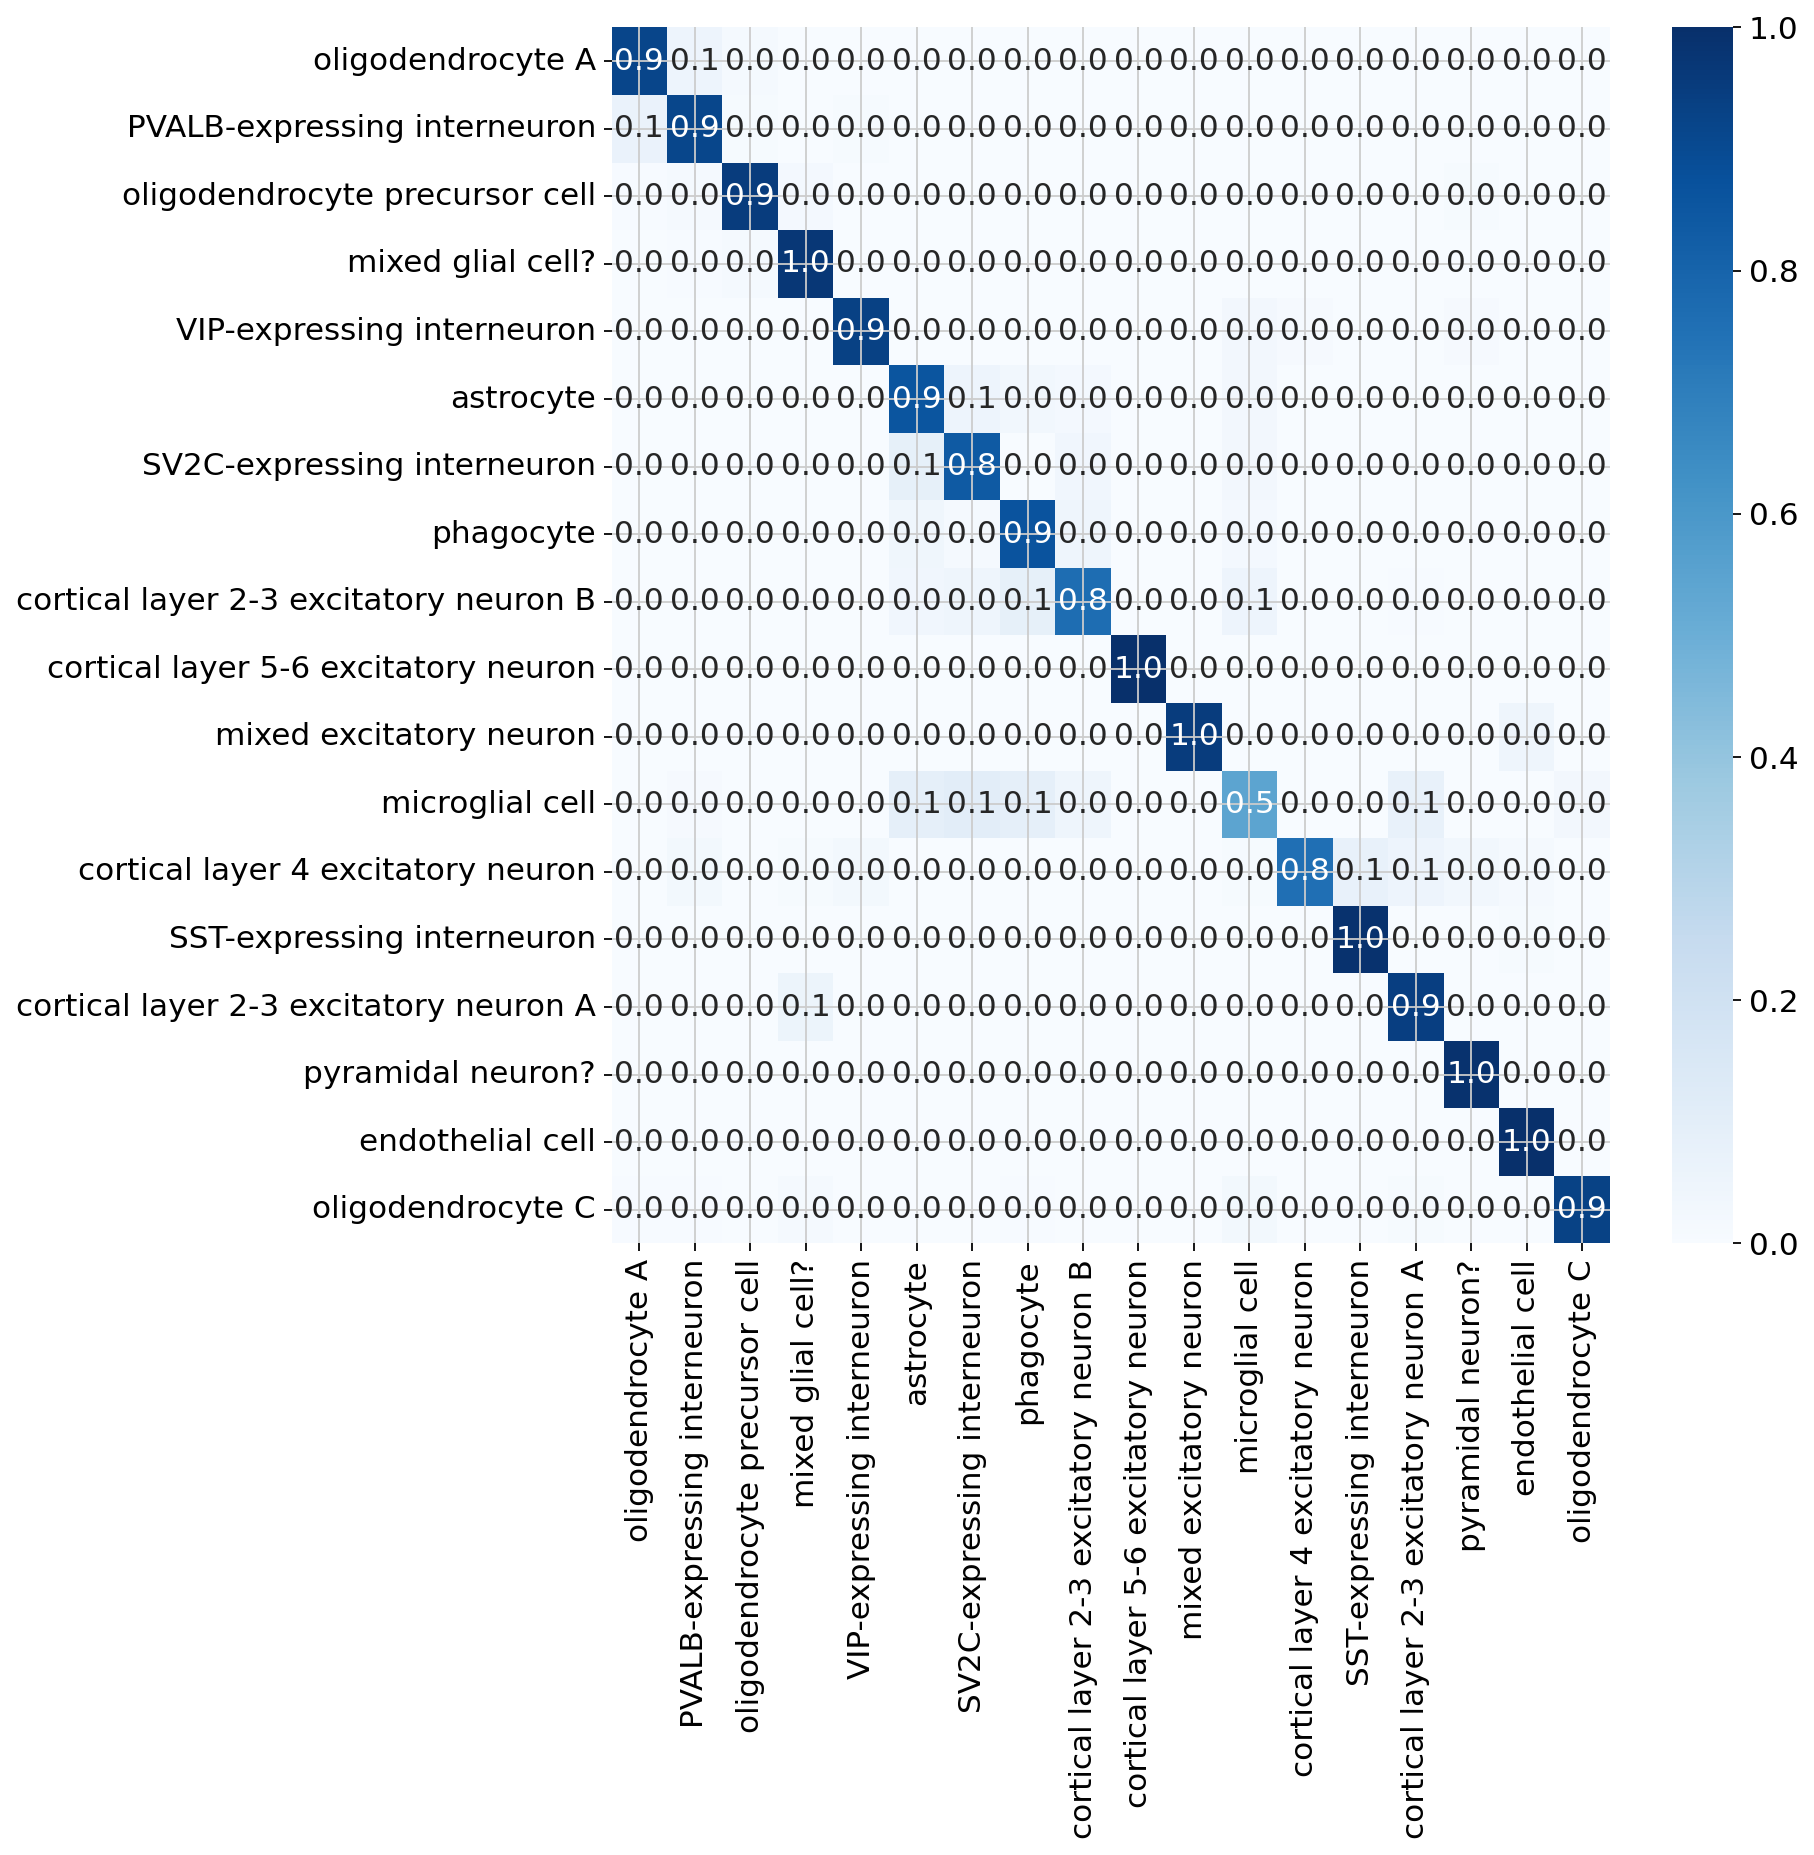

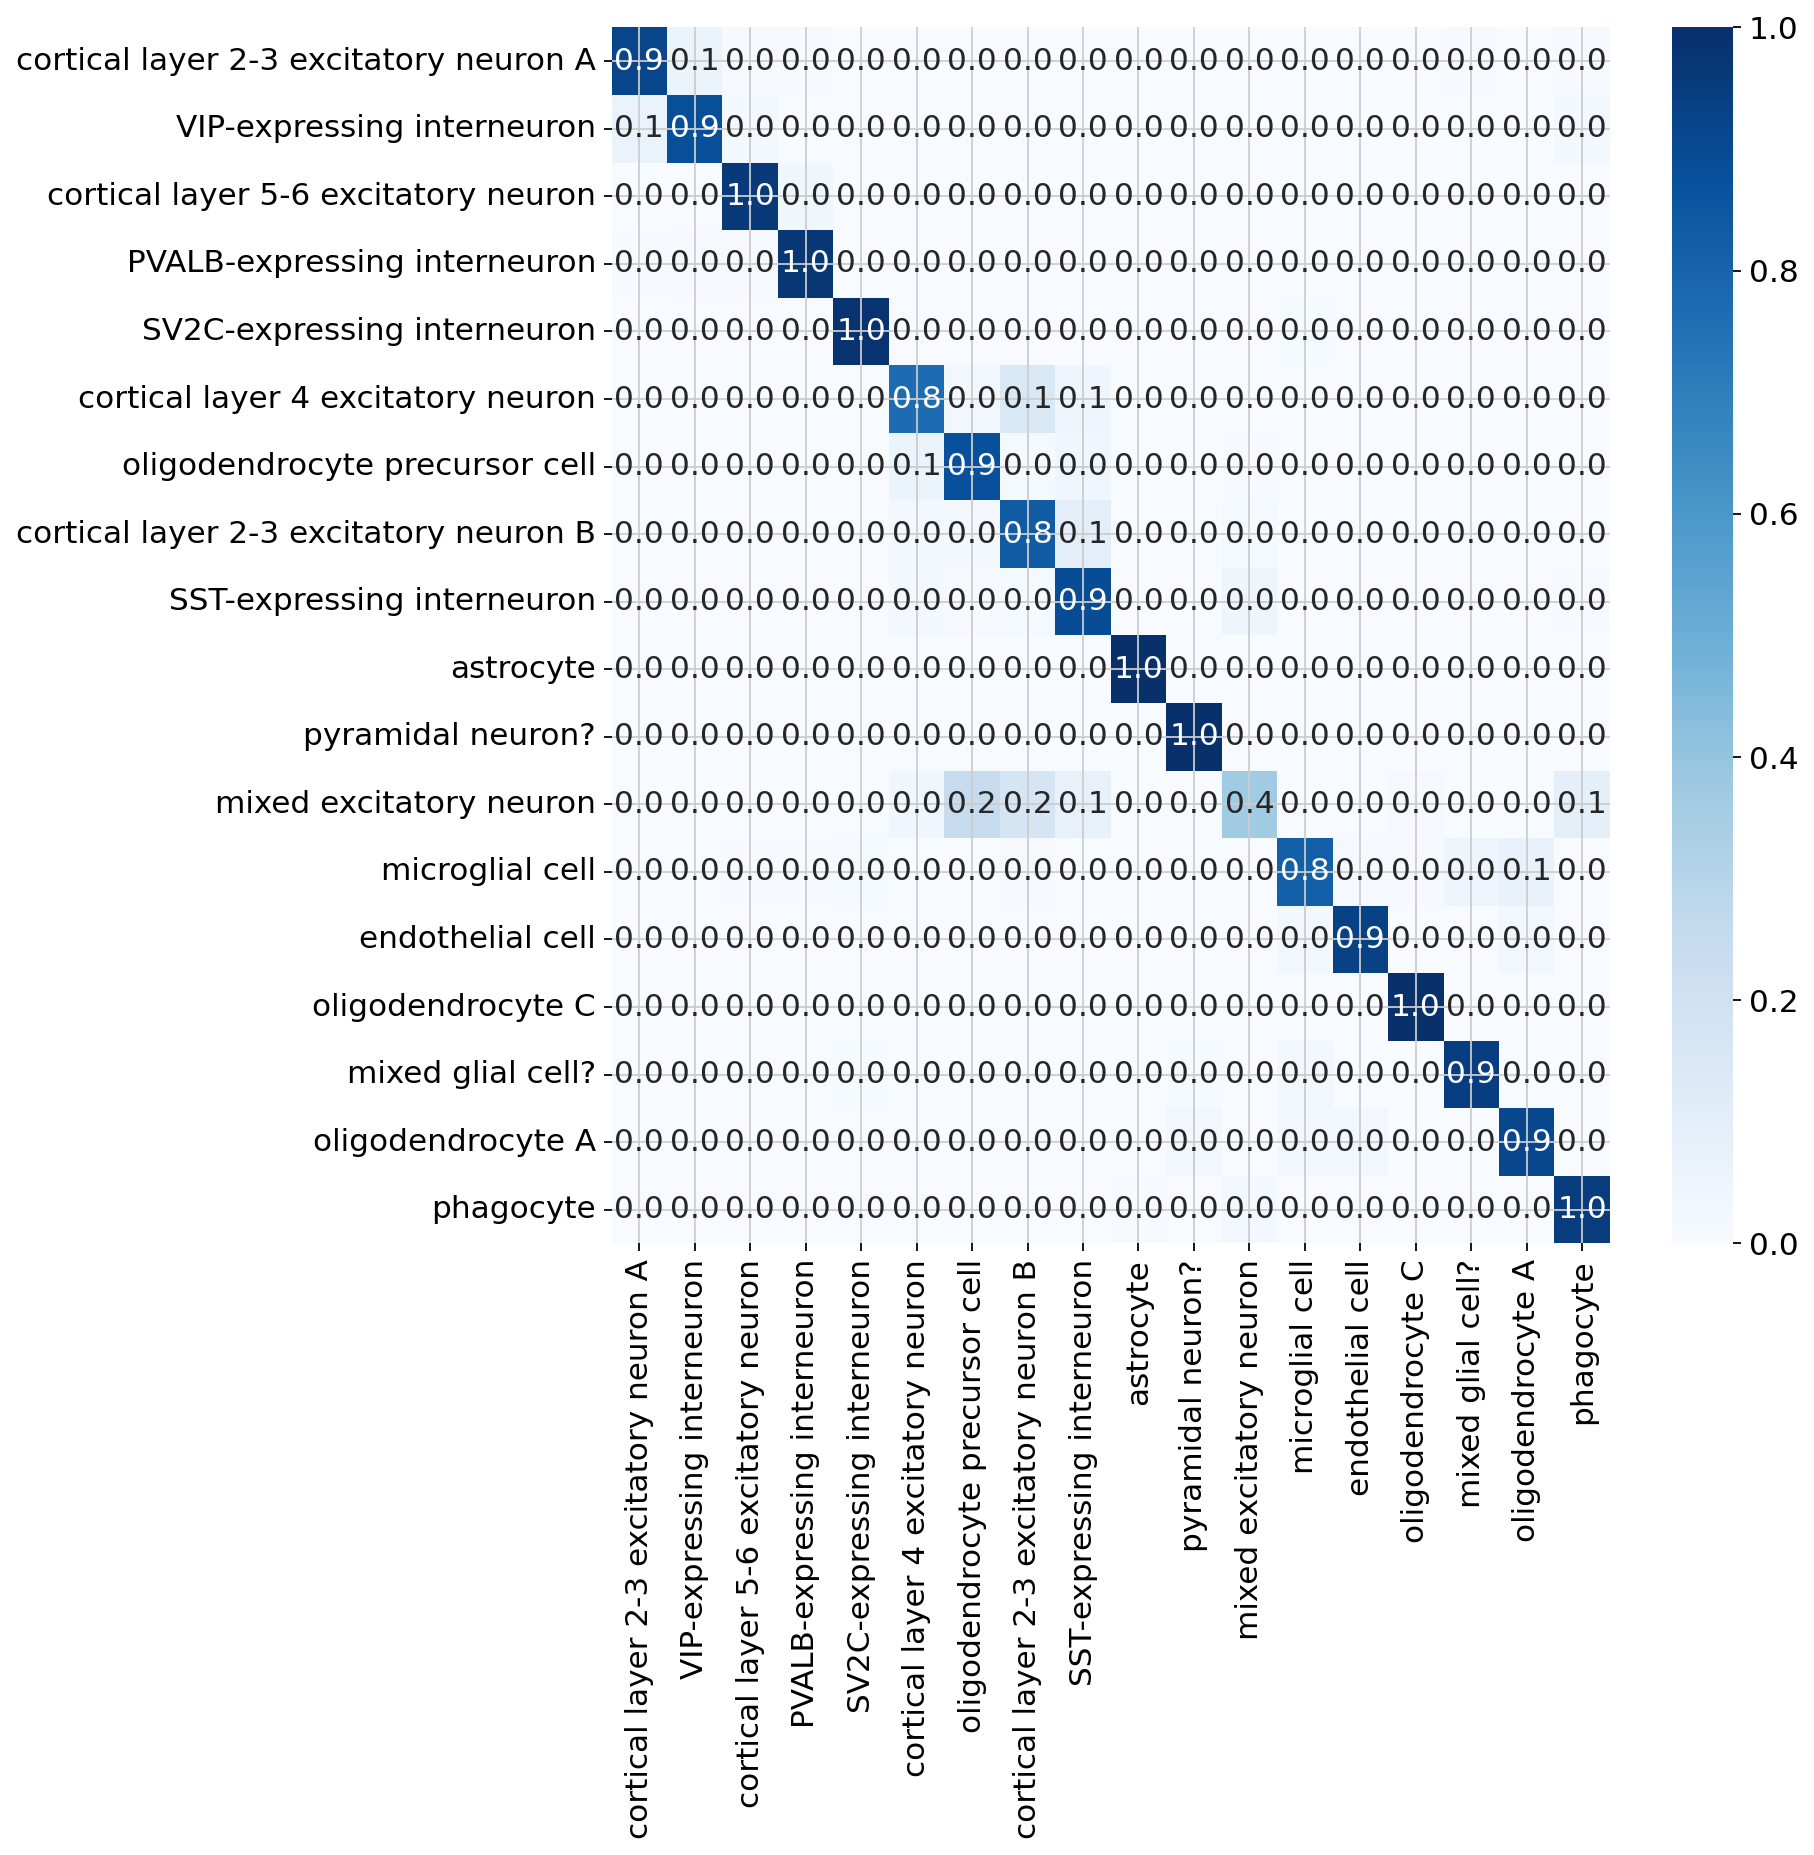

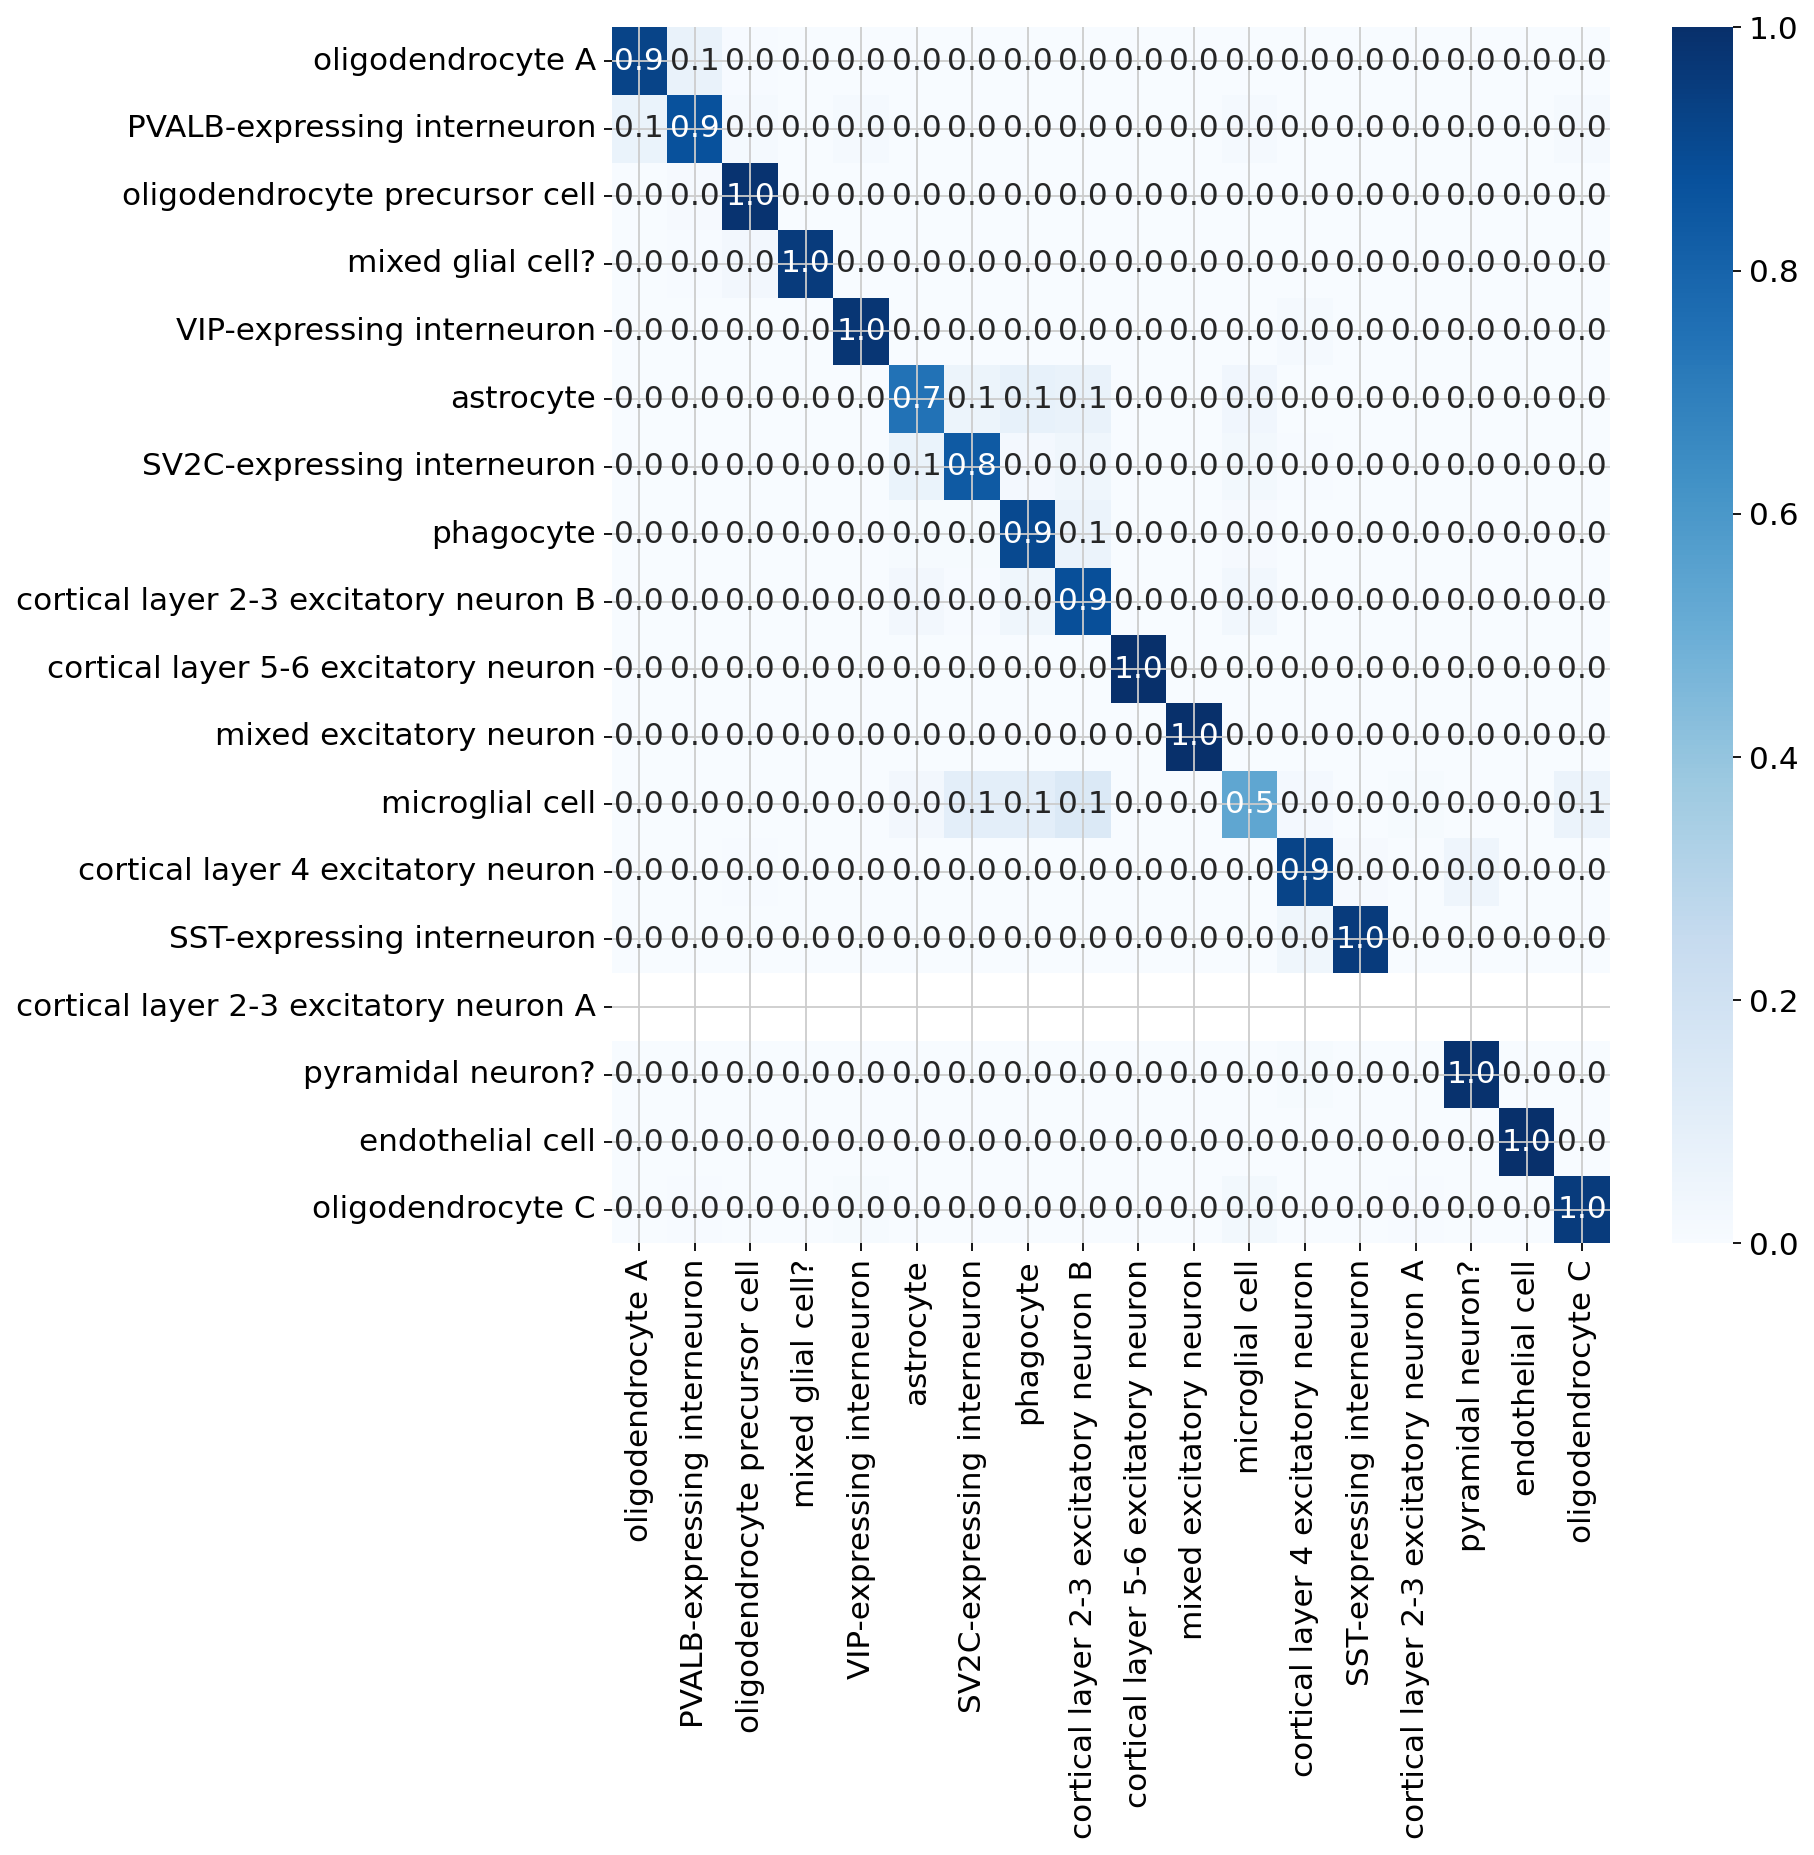

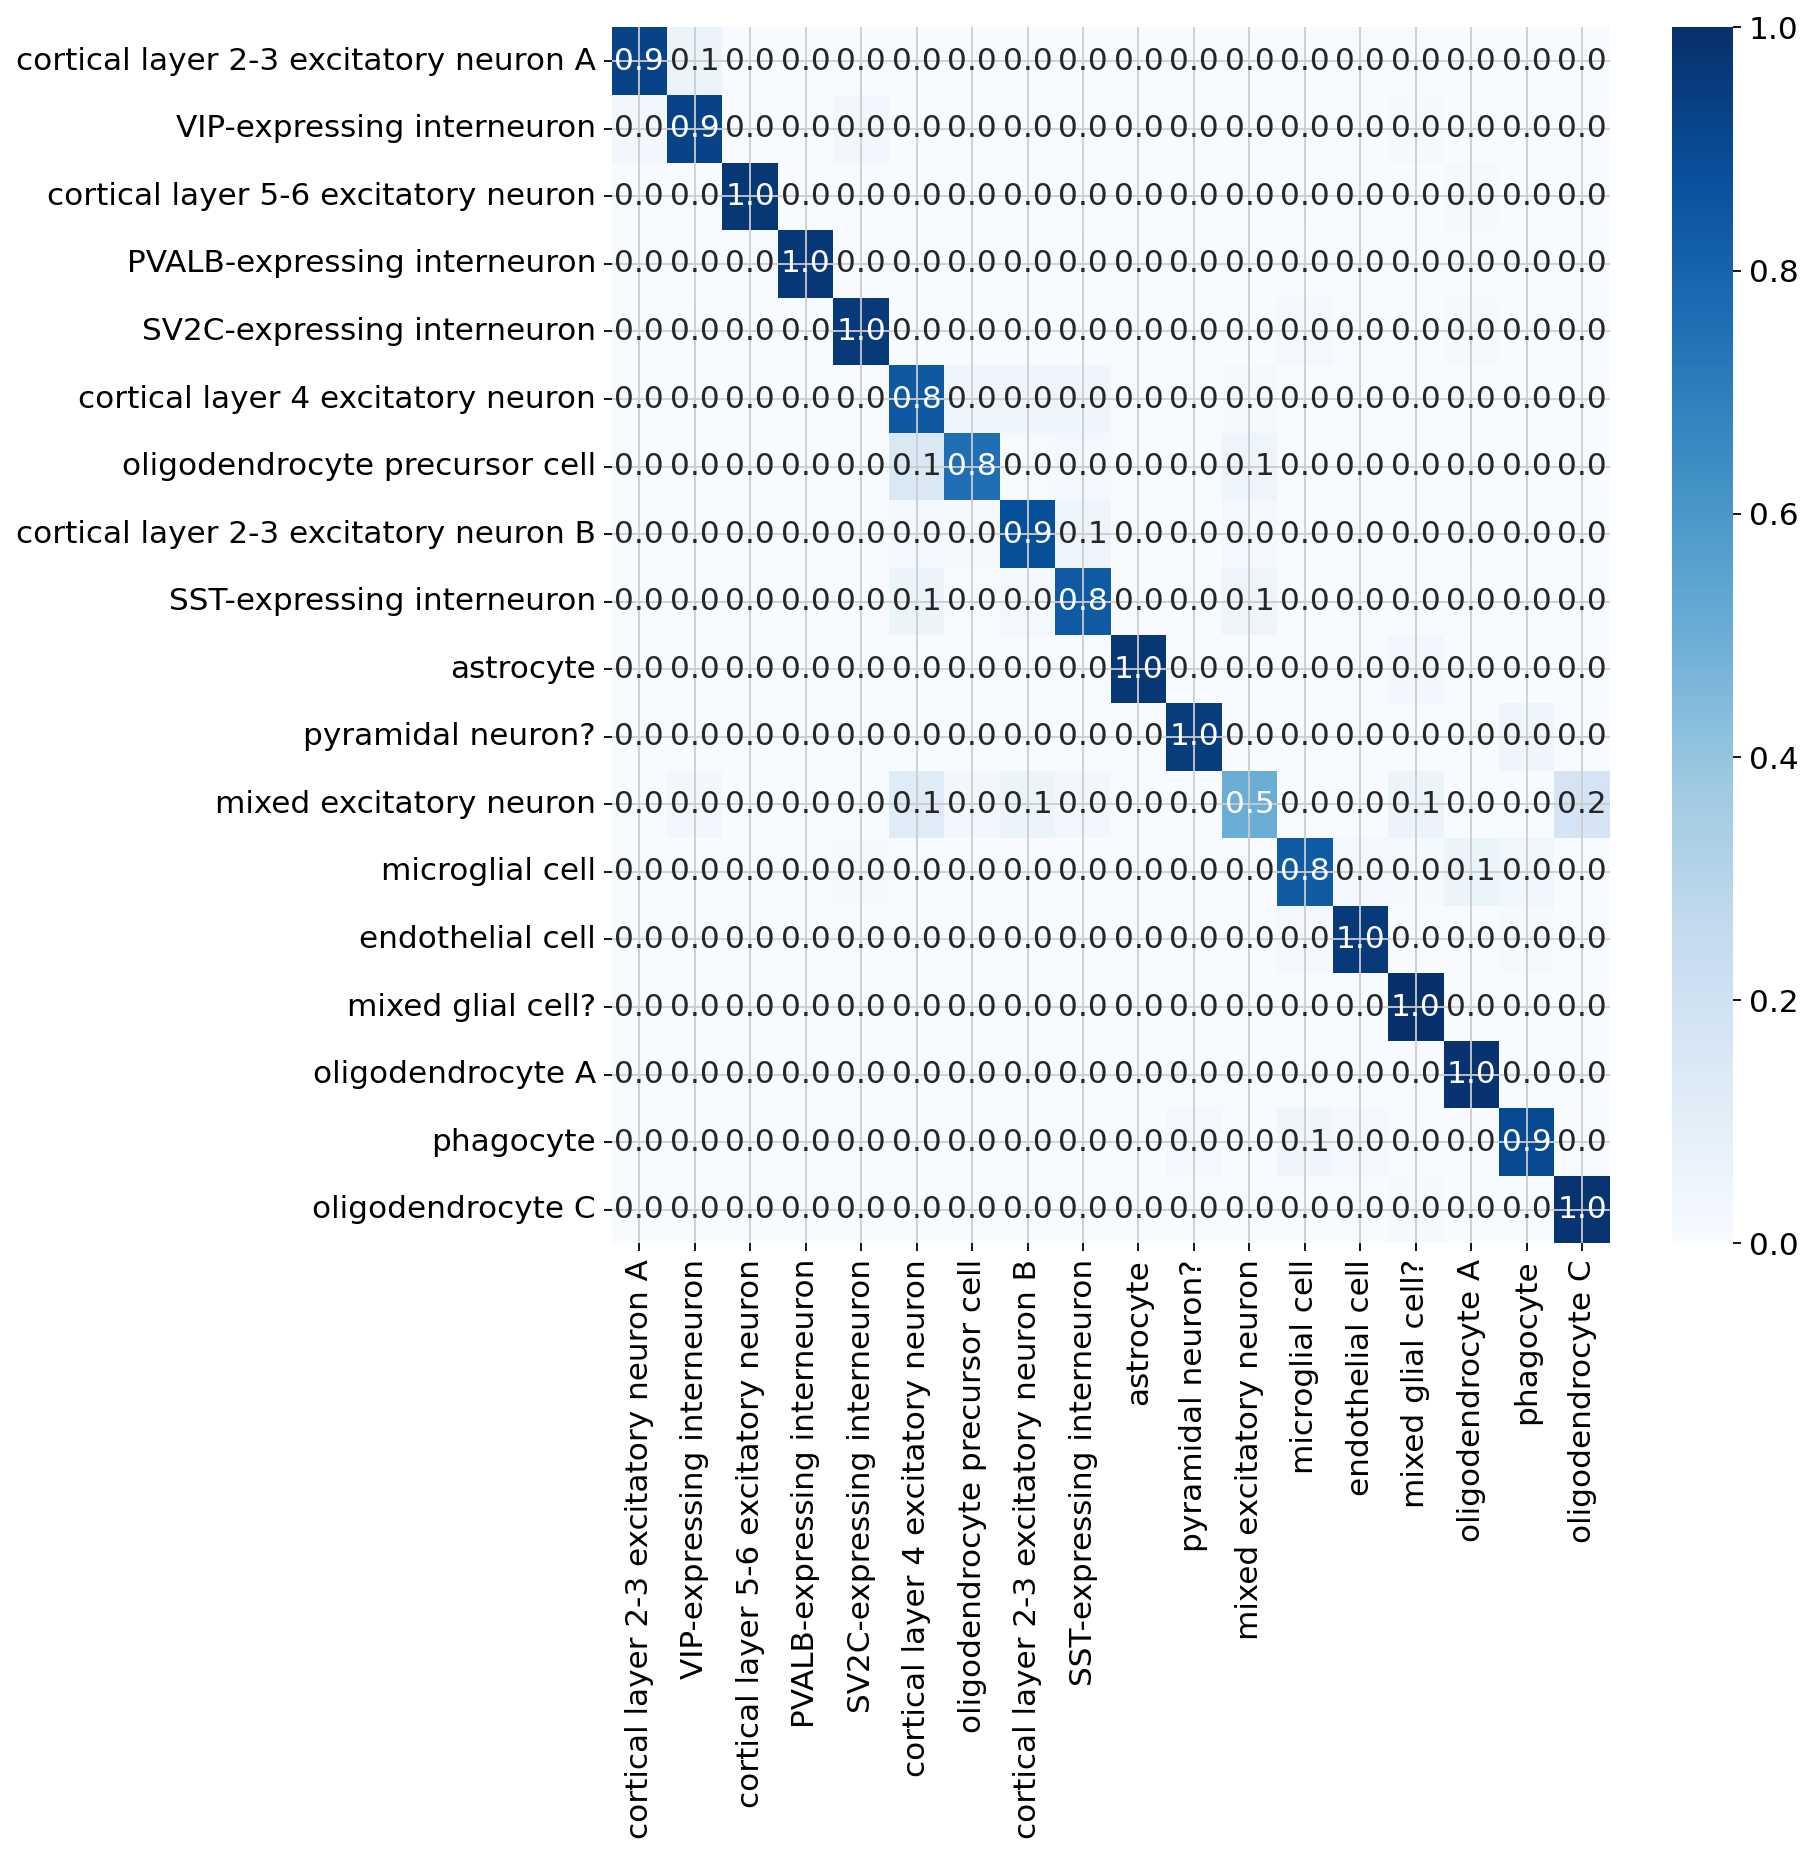

In [10]:
f1 = []
rec = []
acc = []
pre = []
n_splits = 5

for fold_index in range(n_splits):
    logger.info("-" * 89)
    logger.info(f"FOLD: {fold_index}")
    
    # load and process adata for tokenizing
    tokenized_data, data_global_describe = load_and_process_data(dataset_name, fold_index, config, vocab, logger)

    # init and load pre-trained model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = initialize_model(config, vocab, device, logger, data_global_describe)

    # add class weights for criterion_cls
    class_num = np.unique(data_global_describe["celltype_id_labels"], return_counts=True)[1].tolist()
    class_weight = torch.tensor([(1 - (x / sum(class_num))) ** 2 for x in class_num]).to(device)
    criterion_cls = nn.CrossEntropyLoss(weight=class_weight)

    # init optimizer scheduler and scaler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-4 if config.amp else 1e-8)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, schedule_interval, gamma=config.schedule_ratio)
    scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

    # prepare train and valid dataloader
    train_data_pt, valid_data_pt = prepare_data(sort_seq_batch=False, config=config, **tokenized_data)
    train_sampler = get_weighted_sampler(train_data_pt, data_global_describe)

    train_loader = prepare_dataloader(
        data_pt=train_data_pt,
        batch_size=batch_size,
        shuffle=False,
        intra_domain_shuffle=True,
        drop_last=False,
        sampler=train_sampler
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=eval_batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
    )

    best_val_loss = float("inf")
    best_model = None
    patience = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        if config.do_train:
            train(
                model=model,
                loader=train_loader,
                vocab=vocab,
                criterion_cls=criterion_cls,
                scaler=scaler,
                optimizer=optimizer,
                scheduler=scheduler,
                device=device,
                config=config,
                logger=logger,
                epoch=epoch,
                criterion_gep_gepc=masked_mse_loss,
                criterion_dab=nn.CrossEntropyLoss()
            )

        val_loss = evaluate(
            model=model,
            loader=valid_loader,
            vocab=vocab,
            criterion_cls=criterion_cls,
            device=device,
            config=config,
            epoch=epoch,
            criterion_gep_gepc=masked_mse_loss,
            criterion_dab=nn.CrossEntropyLoss()
        )

        elapsed = time.time() - epoch_start_time
        logger.info("-" * 89)
        logger.info(
            f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
            f"valid loss/mse {val_loss:5.4f}"
        )
        logger.info("-" * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            best_model_epoch = epoch
            logger.info(f"Best model with score {best_val_loss:5.4f}")
            patience = 0
        else:
            patience += 1
            if patience >= early_stop:
                logger.info(f"Early stop at epoch {epoch}")
                break

        scheduler.step()

    
    logger.info(f"fold_{fold_index}: ")
    adata_test = data_global_describe["adata_test"]
    predictions, labels, results = test(
        model=best_model,
        adata=adata_test,
        gene_ids=data_global_describe["gene_ids"],
        vocab=vocab,
        config=config,
        device=device,
        logger=logger
    )
    
    f1.append(results["test/macro_f1"])
    acc.append(results["test/accuracy"])
    pre.append(results["test/precision"])
    rec.append(results["test/recall"])

    id2type = data_global_describe["id2type"]
    save_dict = {
        "predictions": predictions,
        "labels": labels,
        "results": results,
        "id_maps": id2type
    }
    with open(save_dir / f"results_fold_{fold_index}.pkl", "wb") as f:
        pickle.dump(save_dict, f)

    from sklearn.metrics import confusion_matrix

    celltypes = list(data_global_describe["celltypes"])
    for i in set([id2type[p] for p in predictions]):
        if i not in celltypes:
            celltypes.remove(i)
    cm = confusion_matrix(labels, predictions)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm = pd.DataFrame(cm, index=celltypes[:cm.shape[0]], columns=celltypes[:cm.shape[1]])
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")
    plt.savefig(save_dir / f"confusion_matrix_fold_{fold_index}.png", dpi=300)

    # save the model into the save_dir
    torch.save(best_model.state_dict(), save_dir / f"model_fold_{fold_index}.pt")

In [11]:
logger.info(" Aver outcome:"
            f"Balanced accuracy: {np.mean(acc):.3f}, Precision: {np.mean(pre):.3f}, Recall: {np.mean(rec):.3f}, "
            f"macro F1: {np.mean(f1):.3f}"
            )
logger.info(" Variance outcome:"
            f"Balanced accuracy: {np.sqrt(np.var(acc)):.3f}, Precision: {np.sqrt(np.var(pre)):.3f}, "
            f"Recall: {np.sqrt(np.var(rec)):.3f}, macro F1: {np.sqrt(np.var(f1)):.3f}"
            )

scGPT - INFO -  Aver outcome:Balanced accuracy: 0.894, Precision: 0.826, Recall: 0.884, macro F1: 0.844
scGPT - INFO -  Variance outcome:Balanced accuracy: 0.010, Precision: 0.013, Recall: 0.015, macro F1: 0.008
